In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features_for_input = [
#     'q1_tokenized',
#     'q2_tokenized',
#     'q1_pos_tagged',
#     'q2_pos_tagged',
    'clean_q1_lemmatized',
    'clean_q2_lemmatized'
]
def read_data(t):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features_for_input:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

train = read_data('train')#[:1000]
test = read_data('test')#[:1000]

In [3]:
len(train)

404290

In [4]:
import en_core_web_md
nlp = en_core_web_md.load()

In [5]:
def to_str(a):
    return ' '.join(map(str, a))

def similarity(a, b):
    return nlp(to_str(a)).similarity(nlp(to_str(b)))

In [6]:
def n_sim(row):
    return similarity(row.clean_q1_lemmatized, row.clean_q2_lemmatized)

def n_sim_stop(row):
    w1 = [w for w in row['clean_q1_lemmatized'] if w not in stops]
    w2 = [w for w in row['clean_q2_lemmatized'] if w not in stops]
    return similarity(w1, w2)

In [7]:
train['n_sim_lemm_spacy'] = train.apply(n_sim, axis=1, raw=True)
test['n_sim_lemm_spacy'] = test.apply(n_sim, axis=1, raw=True)

In [8]:
train['n_sim_lemm_stop_spacy'] = train.apply(n_sim_stop, axis=1, raw=True)
test['n_sim_lemm_stop_spacy'] = test.apply(n_sim_stop, axis=1, raw=True)

In [9]:
features = [
    'n_sim_lemm_spacy',
    'n_sim_lemm_stop_spacy',
]

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 8.0)

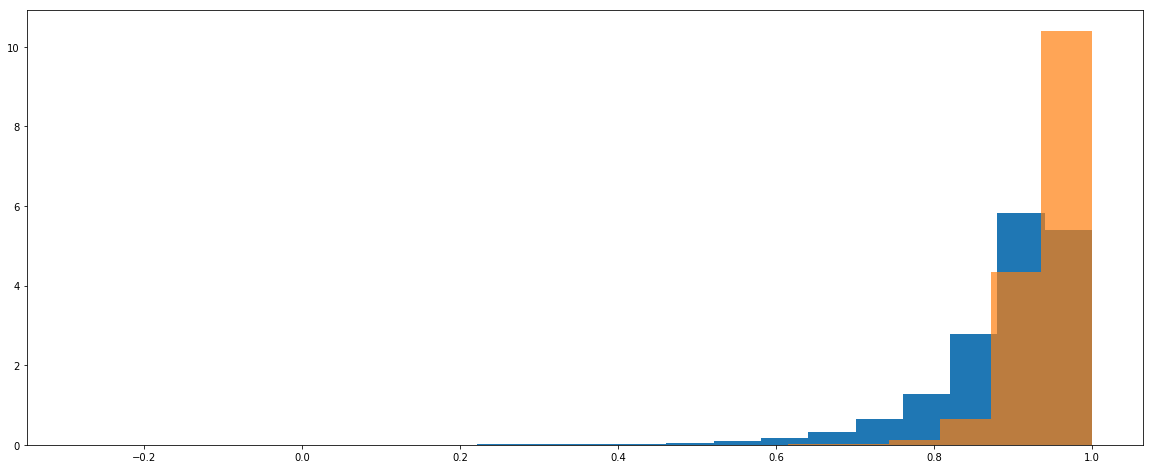

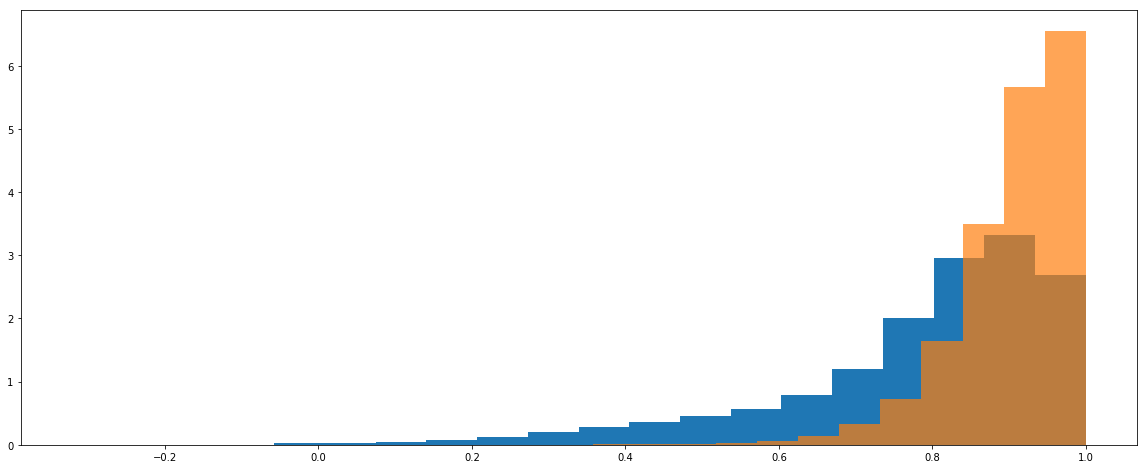

In [11]:
for feature in features:
    plt.hist(train[feature][train['is_duplicate'] == 0], bins=20, normed=True, label='0')
    plt.hist(train[feature][train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
    plt.show()

In [12]:
import util
util.save_feature(train, 'train', features, 'id')
util.save_feature(test, 'test', features, 'test_id')